# Exp 117-121 analysis

See `./informercial/Makefile` for experimental
details.

In [15]:
import os
import numpy as np

from IPython.display import Image
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_style('ticks')

matplotlib.rcParams.update({'font.size': 16})
matplotlib.rc('axes', titlesize=16)

from pprint import pprint

from infomercial.exp import wsls_bandit
from infomercial.exp import epsilon_bandit
from infomercial.exp import beta_bandit
from infomercial.exp import softbeta_bandit
from infomercial.local_gym import bandit
from infomercial.exp.wsls_bandit import load_checkpoint

import gym

In [4]:
def plot_meta(env_name, result):
    """Plots!"""
    
    # episodes, actions, scores_E, scores_R, values_E, values_R, ties, policies
    episodes = result["episodes"]
    actions =result["actions"]
    bests =result["p_bests"]
    scores_E = result["scores_E"]
    scores_R = result["scores_R"]
    values_R = result["values_R"]
    values_E = result["values_E"]
    ties = result["ties"]
    policies = result["policies"]
    
    # -
    env = gym.make(env_name)
    best = env.best
    print(f"Best arm: {best}, last arm: {actions[-1]}")

    # Plotz
    fig = plt.figure(figsize=(6, 14))
    grid = plt.GridSpec(6, 1, wspace=0.3, hspace=0.8)

    # Arm
    plt.subplot(grid[0, 0])
    plt.scatter(episodes, actions, color="black", alpha=.5, s=2, label="Bandit")
    plt.plot(episodes, np.repeat(best, np.max(episodes)+1), 
             color="red", alpha=0.8, ls='--', linewidth=2)
    plt.ylim(-.1, np.max(actions)+1.1)
    plt.ylabel("Arm choice")
    plt.xlabel("Episode")

    # Policy
    policies = np.asarray(policies)
    episodes = np.asarray(episodes)
    plt.subplot(grid[1, 0])
    m = policies == 0
    plt.scatter(episodes[m], policies[m], alpha=.4, s=2, label="$\pi_E$", color="purple")
    m = policies == 1
    plt.scatter(episodes[m], policies[m], alpha=.4, s=2, label="$\pi_R$", color="grey")
    plt.ylim(-.1, 1+.1)
    plt.ylabel("Controlling\npolicy")
    plt.xlabel("Episode")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    _ = sns.despine()
    
    # score
    plt.subplot(grid[2, 0])
    plt.scatter(episodes, scores_E, color="purple", alpha=0.4, s=2, label="E")
    plt.plot(episodes, scores_E, color="purple", alpha=0.4)
    plt.scatter(episodes, scores_R, color="grey", alpha=0.4, s=2, label="R")
    plt.plot(episodes, scores_R, color="grey", alpha=0.4)
    plt.plot(episodes, np.repeat(tie_threshold, np.max(episodes)+1), 
             color="violet", alpha=0.8, ls='--', linewidth=2)
    plt.ylabel("Score")
    plt.xlabel("Episode")
#     plt.semilogy()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    _ = sns.despine()

    # Q
    plt.subplot(grid[3, 0])
    plt.scatter(episodes, values_E, color="purple", alpha=0.4, s=2, label="$Q_E$")
    plt.scatter(episodes, values_R, color="grey", alpha=0.4, s=2, label="$Q_R$")
    plt.plot(episodes, np.repeat(tie_threshold, np.max(episodes)+1), 
             color="violet", alpha=0.8, ls='--', linewidth=2)
    plt.ylabel("Value")
    plt.xlabel("Episode")
#     plt.semilogy()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    _ = sns.despine()

    
    # Ties
    plt.subplot(grid[4, 0])
    plt.scatter(episodes, bests, color="red", alpha=.5, s=2)
    plt.ylabel("p(best)")
    plt.xlabel("Episode")
    plt.ylim(0, 1)

    # Ties
    plt.subplot(grid[5, 0])
    plt.scatter(episodes, ties, color="black", alpha=.5, s=2, label="$\pi_{tie}$ : 1\n $\pi_\pi$ : 0")
    plt.ylim(-.1, 1+.1)
    plt.ylabel("Ties index")
    plt.xlabel("Episode")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    
def plot_epsilon(env_name, result):
    """Plots!"""
    
    # episodes, actions, scores_E, scores_R, values_E, values_R, ties, policies
    episodes = result["episodes"]
    actions =result["actions"]
    bests =result["p_bests"]
    scores_R = result["scores_R"]
    values_R = result["values_R"]
    epsilons = result["epsilons"]
    
    # -
    env = gym.make(env_name)
    best = env.best
    print(f"Best arm: {best}, last arm: {actions[-1]}")

    # Plotz
    fig = plt.figure(figsize=(6, 14))
    grid = plt.GridSpec(6, 1, wspace=0.3, hspace=0.8)

    # Arm
    plt.subplot(grid[0, 0])
    plt.scatter(episodes, actions, color="black", alpha=.5, s=2, label="Bandit")
    plt.plot(episodes, np.repeat(best, np.max(episodes)+1), 
             color="red", alpha=0.8, ls='--', linewidth=2)
    plt.ylim(-.1, np.max(actions)+1.1)
    plt.ylabel("Arm choice")
    plt.xlabel("Episode")

    # score
    plt.subplot(grid[1, 0])
    plt.scatter(episodes, scores_R, color="grey", alpha=0.4, s=2, label="R")
    plt.ylabel("Score")
    plt.xlabel("Episode")
#     plt.semilogy()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    _ = sns.despine()

    # Q
    plt.subplot(grid[2, 0])
    plt.scatter(episodes, values_R, color="grey", alpha=0.4, s=2, label="$Q_R$")
    plt.ylabel("Value")
    plt.xlabel("Episode")
#     plt.semilogy()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    _ = sns.despine()

    # best
    plt.subplot(grid[3, 0])
    plt.scatter(episodes, bests, color="red", alpha=.5, s=2)
    plt.ylabel("p(best)")
    plt.xlabel("Episode")
    plt.ylim(0, 1)

    # Decay
    plt.subplot(grid[4, 0])
    plt.scatter(episodes, epsilons, color="black", alpha=.5, s=2)
    plt.ylabel("$\epsilon_R$")
    plt.xlabel("Episode")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
def plot_critic(critic_name, env_name, result):
    # -
    env = gym.make(env_name)
    best = env.best
    
    # Data
    critic = result[critic_name]
    arms = list(critic.keys())
    values = list(critic.values())

    # Plotz
    fig = plt.figure(figsize=(8, 3))
    grid = plt.GridSpec(1, 1, wspace=0.3, hspace=0.8)

    # Arm
    plt.subplot(grid[0])
    plt.scatter(arms, values, color="black", alpha=.5, s=30)
    plt.plot([best]*10, np.linspace(min(values), max(values), 10), color="red", alpha=0.8, ls='--', linewidth=2)
    plt.ylabel("Value")
    plt.xlabel("Arm")

# Load and process data

In [7]:
data_path ="/Users/qualia/Code/infomercial/data/"
exp_names = ["exp117","exp118","exp119","exp120","exp121"] 
epsilons = [(0.01, 0.1), (0.101, 0.2), (0.201, 0.3), (0.301, 0.4), (0.401, 0.5)]

best_params = []
for exp_name in exp_names:
    sorted_params = load_checkpoint(os.path.join(data_path, f"{exp_name}_sorted.pkl"))
    best_params.append(sorted_params[0])

In [16]:
# print(sorted_params.keys())
named_best_params = list(zip(epsilons, best_params))
pprint(named_best_params)

[((0.01, 0.1),
  {'epsilon': 0.02024205209906809,
   'lr_R': 0.00010966063194946151,
   'total_R': 1023.0}),
 ((0.101, 0.2),
  {'epsilon': 0.1314416096331582,
   'lr_R': 9.924397024167986e-05,
   'total_R': 971.0}),
 ((0.201, 0.3),
  {'epsilon': 0.21281760135480185,
   'lr_R': 0.00029666507192216337,
   'total_R': 954.0}),
 ((0.301, 0.4),
  {'epsilon': 0.3233174389108657,
   'lr_R': 7.170764536237297e-05,
   'total_R': 883.0}),
 ((0.401, 0.5),
  {'epsilon': 0.42018114155772085,
   'lr_R': 0.0004286494069744599,
   'total_R': 866.0})]


# Performance

of best parameters

Best arm: [7], last arm: 0


No handles with labels found to put in legend.


(0.01, 0.1)
Best arm: [7], last arm: 0


No handles with labels found to put in legend.


(0.101, 0.2)
Best arm: [7], last arm: 0


No handles with labels found to put in legend.


(0.201, 0.3)
Best arm: [7], last arm: 5


No handles with labels found to put in legend.


(0.301, 0.4)
Best arm: [7], last arm: 7


No handles with labels found to put in legend.


(0.401, 0.5)


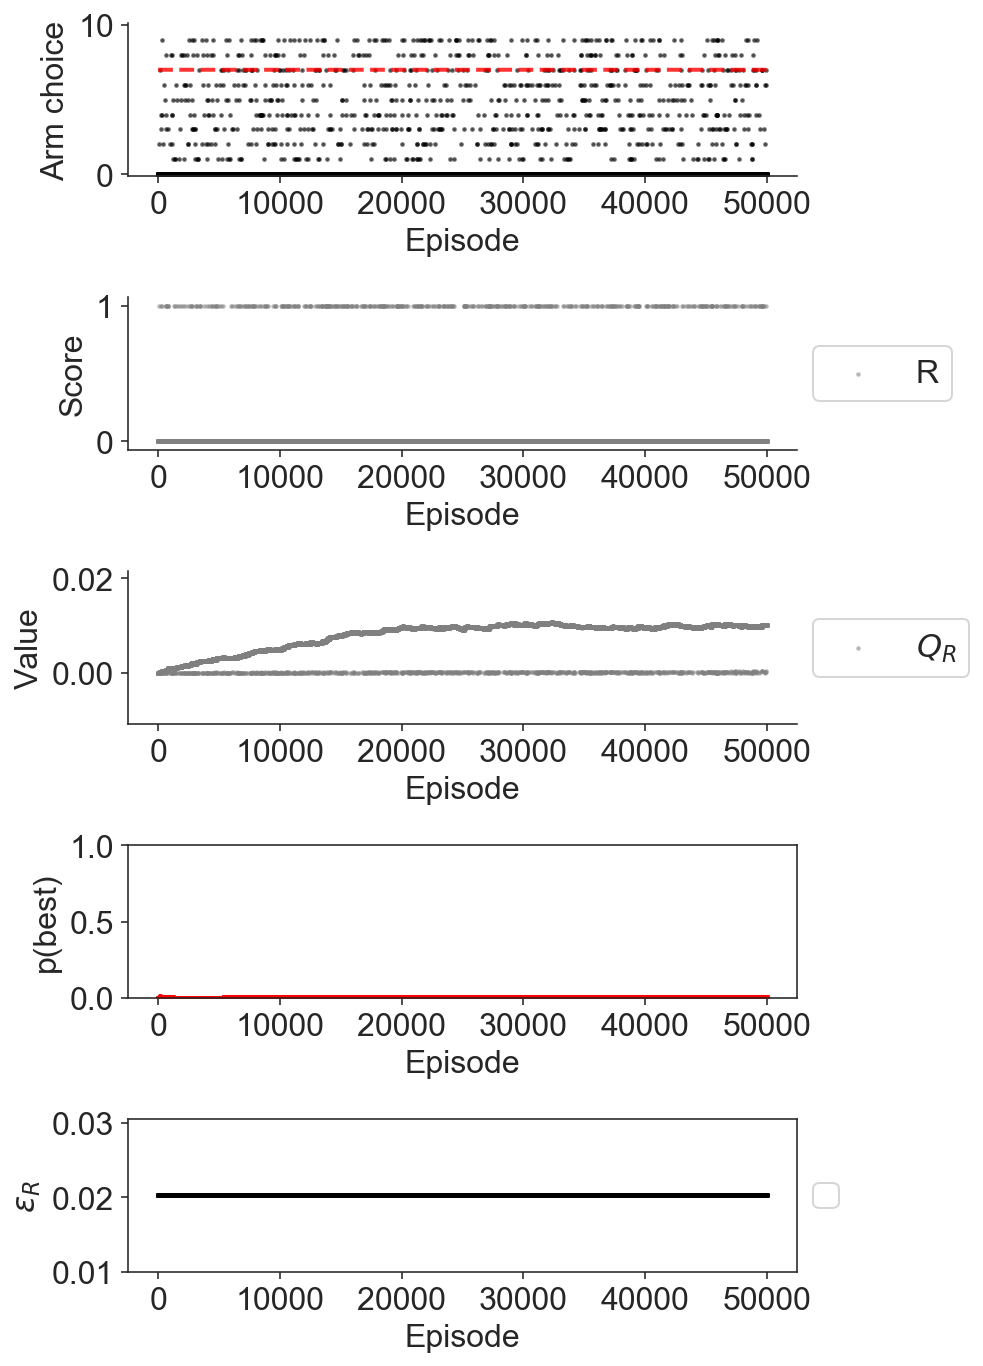

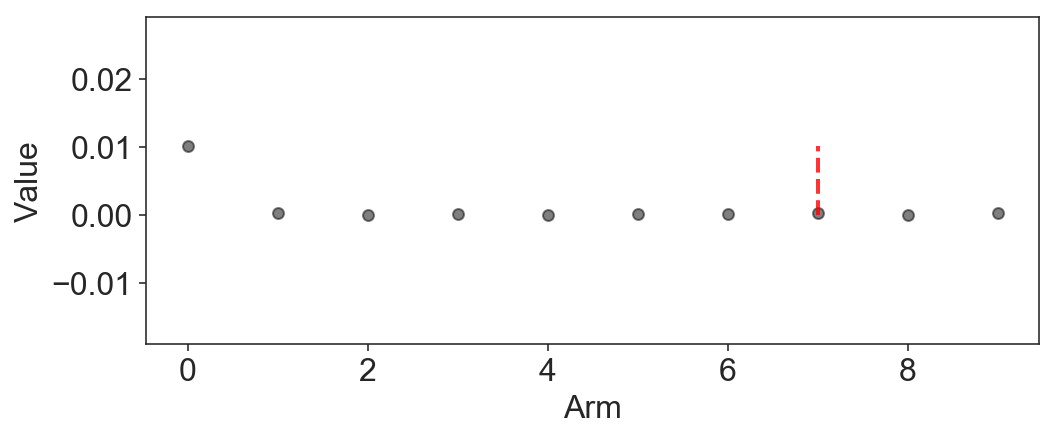

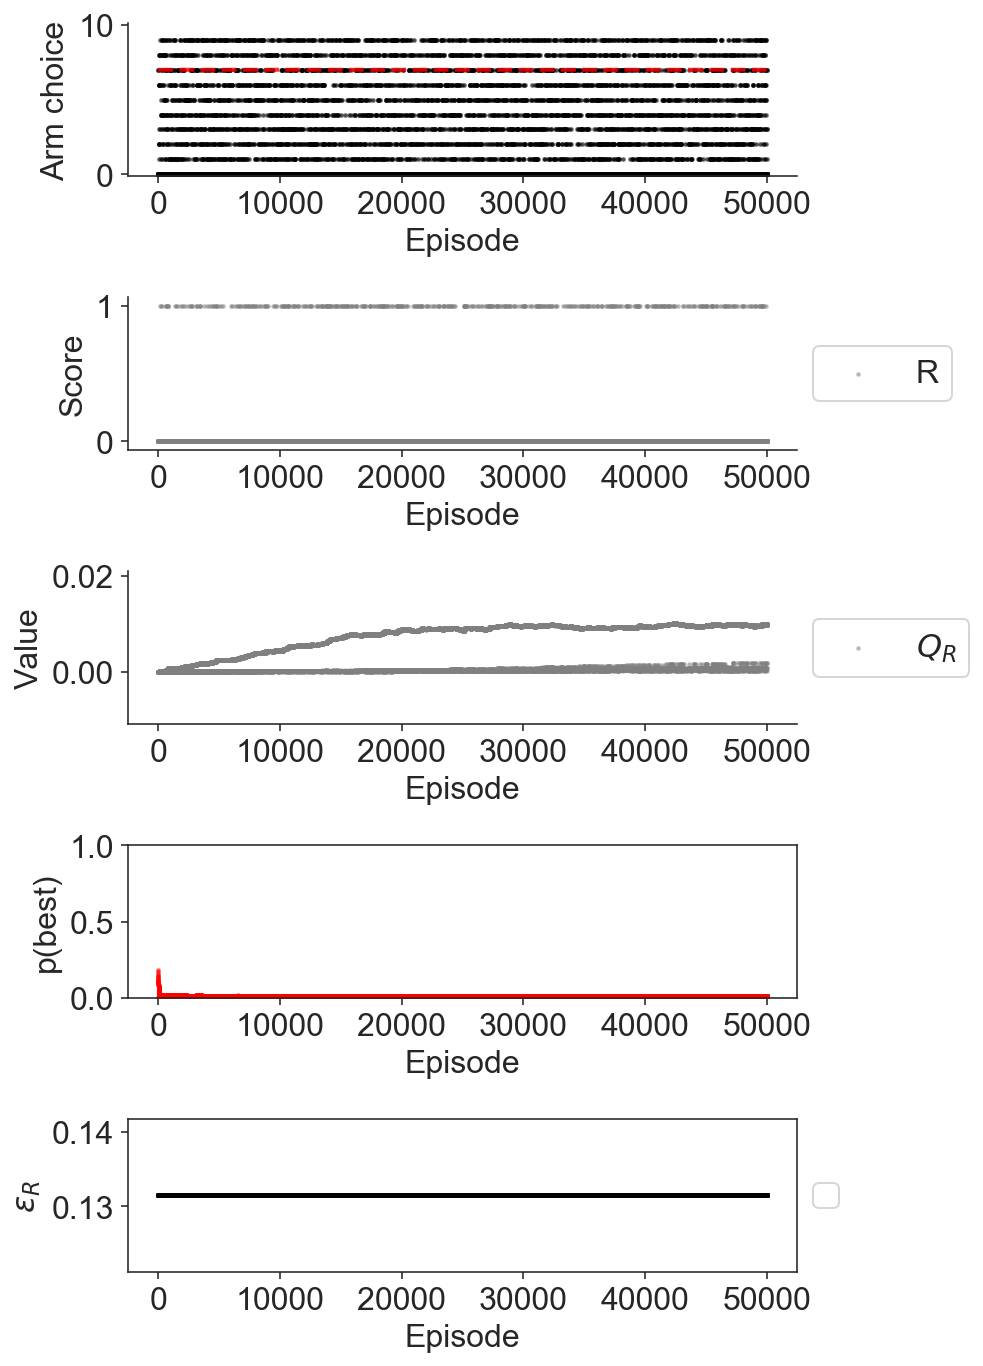

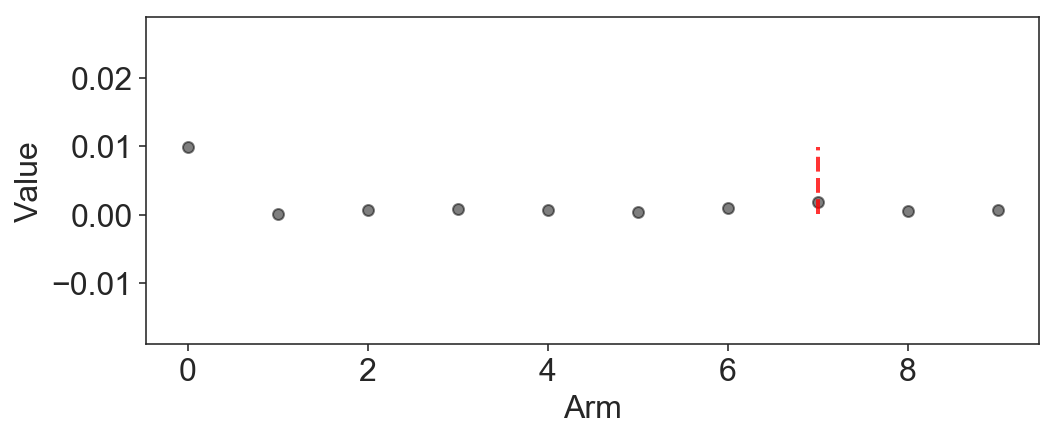

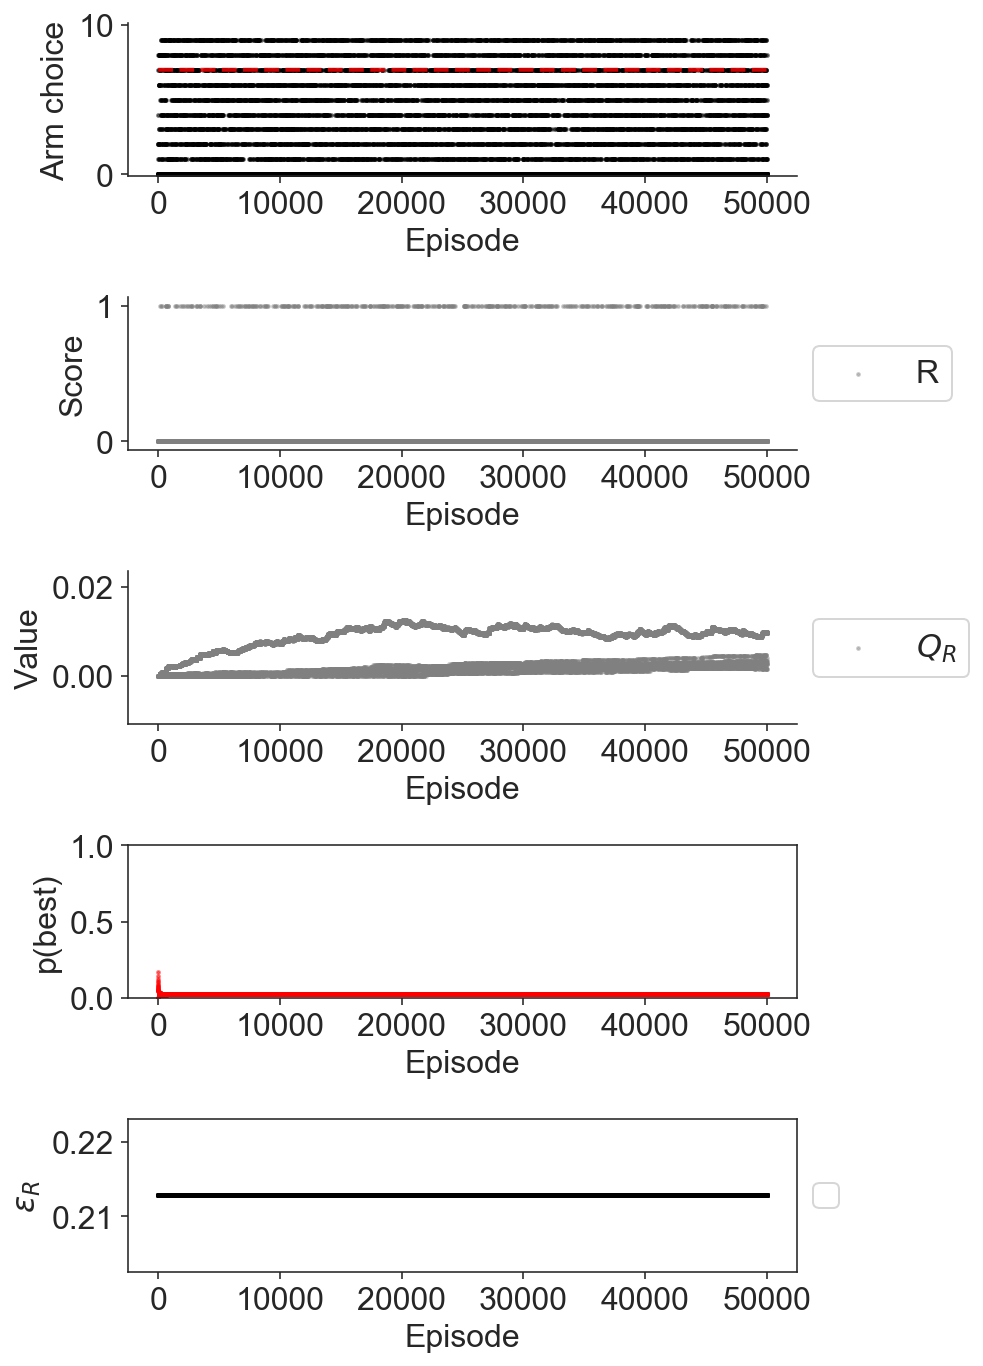

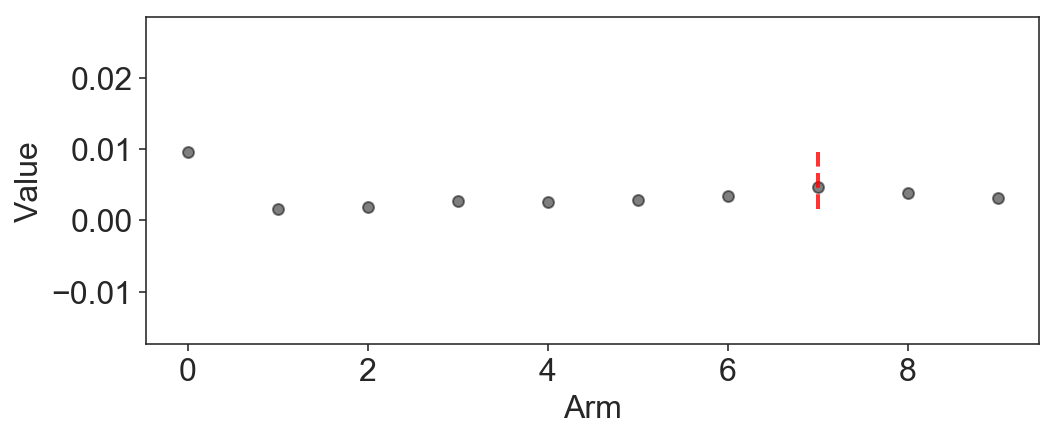

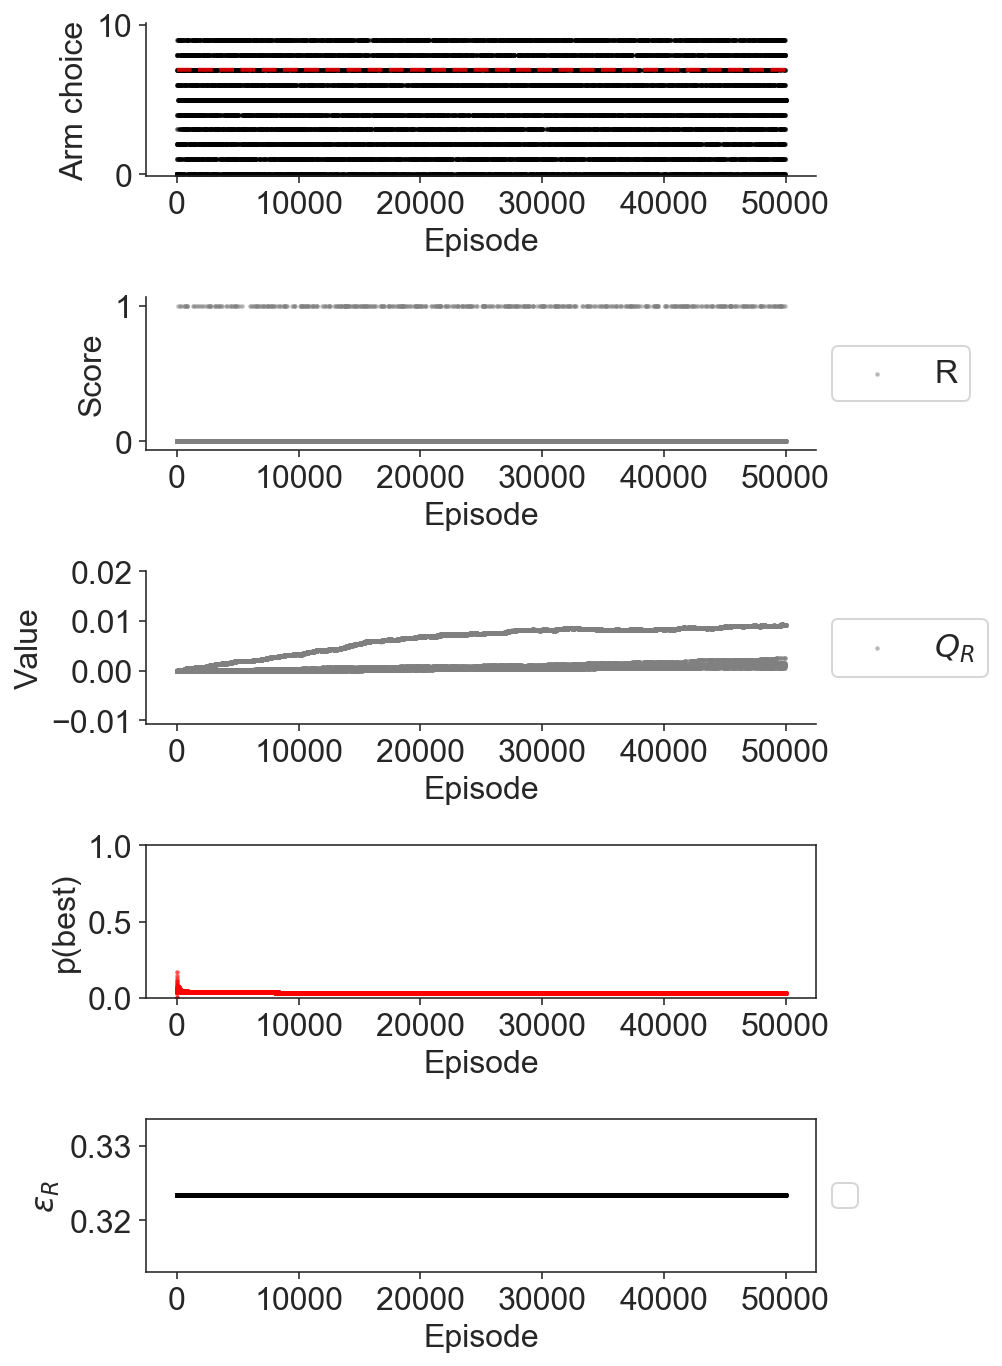

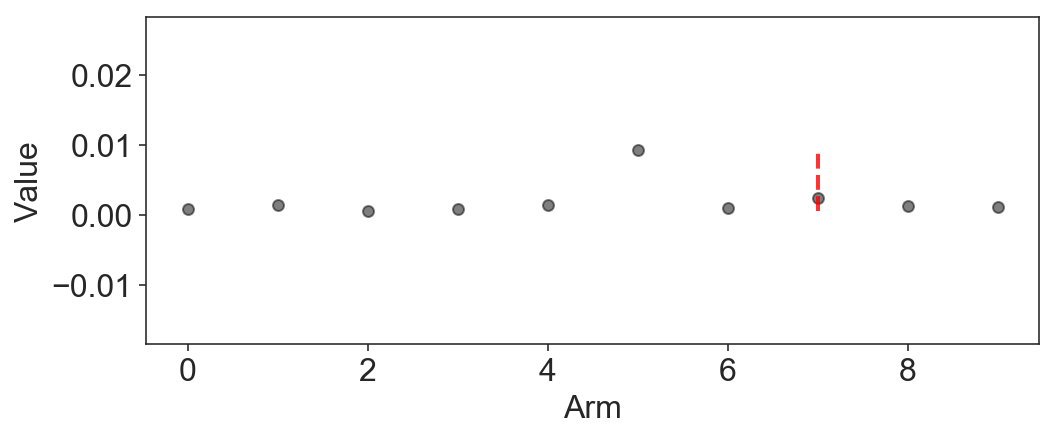

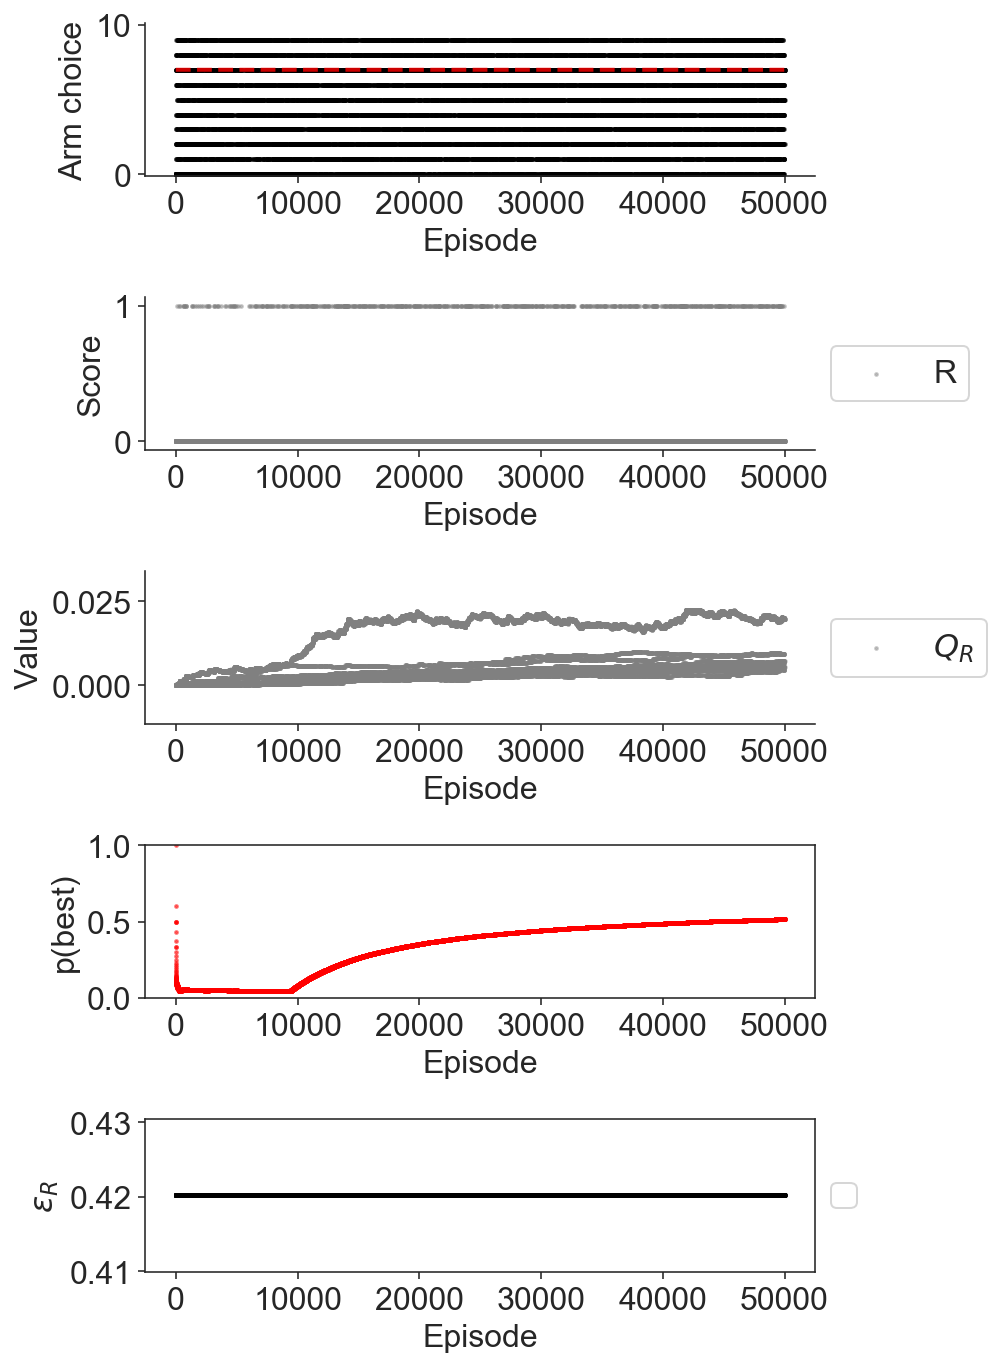

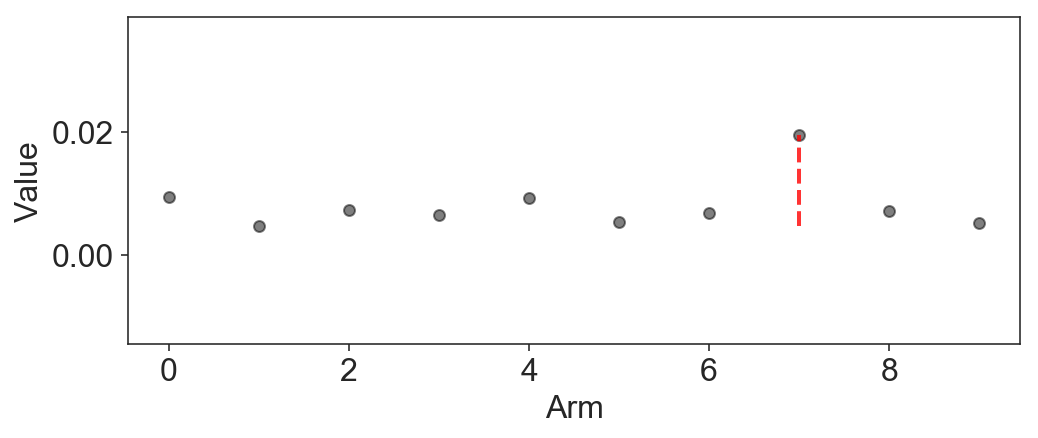

In [19]:
env_name = 'BanditHardAndSparse10-v0'
num_episodes = 50000

for name, best in named_best_params:
    # Run w/ best params
    result = epsilon_bandit(
        env_name=env_name,
        num_episodes=num_episodes, 
        lr_R=best["lr_R"],
        epsilon=best["epsilon"],
        seed_value=2,
    )
    # Plot
    plot_epsilon(env_name, result=result)
    plot_critic('critic_R', env_name, result)
    print(name)